In [1]:
#### t_fwd3_t vs t_fwd3 on train=False (we can't do this testing for train=True due to different RNGs tooling)
import torch
torch.set_printoptions(precision=6)
from torch.func import jacrev
from model_torch_func import init_transformer_gpt2, batched_forward_gpt2
BS, H, N, D = 8, 12, 512, 768 #8, 2, 512, 64
#BS, H, N, D = 8, 12, 512, 768 #8, 2, 512, 64
#BS, H, N, D = 2, 2, 512, 64 # 1, 1, 3, 4 #2, 2, 5, 4
vocab_size = 35374 #
#vocab_size = 128
layers = 12 #12 #2
p_gen_aux = [42] + [43,44,45] * layers
layers_params = init_transformer_gpt2(vocab_size, D, layers, H, 4*D, N)
y= torch.randint(vocab_size, (BS, N+1), device="cuda").to(torch.int32)
y_indices = torch.arange(N, device="cuda").unsqueeze(0).expand(BS, N)
mask = torch.ones((BS, N, N), dtype=torch.bool, device="cuda")
train = False

for i, i_mask in enumerate(mask):
    mask[i] = torch.tril(i_mask)
    #mask[i] = torch.zeros_like(i_mask)
# print(mask)

from model_triton import t_gpt2_forward_with_acts, t_gpt2_forward_with_acts_t
y_in = y[:, :-1]
y_out = y[:, 1:]
 
res2 = batched_forward_gpt2(layers_params, y_in, mask, y_indices, train)
#res2, acts2 = t_gpt2_forward_with_acts(layers_params, y_in, mask, y_indices, train, p_gen_aux)
print(res2)
#print(res2[1])
#print_res_shapes(res2[0]) 

print(f'----X----')

#res3, acts3 = t_gpt2_forward_with_acts(layers_params, y_in, mask, y_indices, train, p_gen_aux)
res3, acts3 = t_gpt2_forward_with_acts_t(layers_params, y_in, mask, y_indices, train, p_gen_aux)
print(res3)
#print_res_shapes(res3[0]) 

assert torch.allclose(res2, res3, rtol=1e-2, atol=5e-3)
#assert torch.allclose(res2, res3, rtol=1e-3, atol=2e-4)

print(f'----XXX----')

def recursive_assert(a, b):
    if isinstance(a, torch.Tensor):
        assert isinstance(b, torch.Tensor)
        assert torch.allclose(a, b, rtol=1e-3, atol=1e-4)
    else:
        assert not isinstance(b, torch.Tensor)
        if len(a) != len(b):
            return
        assert len(a) == len(b), f'len(a) {len(a)}, len(b) {len(b)}'
        for i, (ai, bi) in enumerate(zip(a, b)):
            recursive_assert(ai, bi)
#recursive_assert(acts2, acts3)
print(f'----XXX----')




tensor([[[ 9.801692e-01,  6.702347e-01, -1.198079e-01,  ...,
           6.728294e-01,  1.301589e+00, -6.437355e-01],
         [-3.426032e-01,  6.666589e-02, -6.047209e-01,  ...,
           5.129225e-02, -6.499596e-03, -7.796916e-02],
         [-9.545236e-01,  3.559553e-02,  3.974842e-01,  ...,
          -1.210648e-01,  8.176327e-01, -1.141222e+00],
         ...,
         [ 2.276729e-01,  7.591681e-01,  1.528627e-01,  ...,
           1.988280e-01,  5.091211e-01, -8.982951e-02],
         [-1.240692e+00,  1.460313e-01, -1.601868e-01,  ...,
          -1.197612e-01, -4.631189e-01, -2.505136e-01],
         [-7.669965e-01, -8.562581e-02,  3.638639e-01,  ...,
          -7.010698e-01,  1.139780e+00, -2.286795e-01]],

        [[-1.034930e+00, -2.146296e-02, -3.902445e-01,  ...,
          -1.023915e-01, -2.488870e-02,  1.022084e-01],
         [ 7.560949e-01,  1.993697e-01,  2.007080e-01,  ...,
           6.032662e-01,  8.285748e-01,  1.946904e-01],
         [-2.228076e-01,  1.841757e-01, -5.14514

In [2]:
res2 = res2.reshape(BS*N, vocab_size)
res3 = res3.reshape(BS*N, vocab_size)
#res2.reshape(-1).shape
aerr = torch.abs(res2-res3)
print(aerr.shape)
atol=5e-3
rerr = torch.maximum((aerr - atol) / torch.abs(res2), torch.zeros_like(res2)) # res2 being "other"
print(rerr.shape)
#print(aerr)
#print(rerr)
print(torch.max(aerr, dim=1)[0])
print(torch.max(rerr, dim=1)[0])

torch.Size([4096, 35374])
torch.Size([4096, 35374])
tensor([0.000810, 0.002666, 0.003002,  ..., 0.005776, 0.000873, 0.000522],
       device='cuda:0')
tensor([0.000000e+00, 0.000000e+00, 0.000000e+00,  ..., 5.408167e-05,
        0.000000e+00, 0.000000e+00], device='cuda:0')


In [18]:
torch.max(rerr)

tensor(0.002756, device='cuda:0')

In [39]:
#!pip install seaborn

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots()
ax = sns.heatmap(aerr.cpu().numpy())
plt.show()

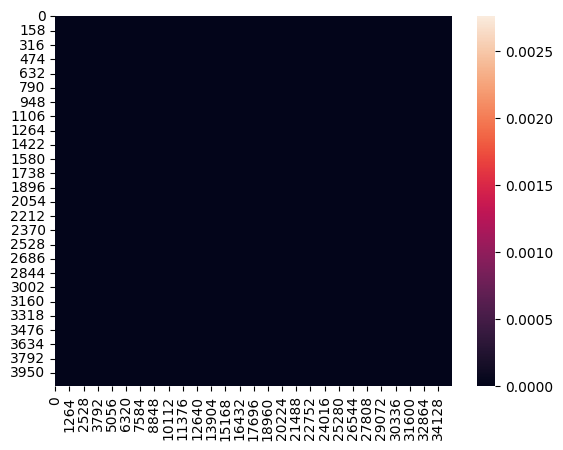

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots()
ax = sns.heatmap(rerr.cpu().numpy())
plt.show()

In [47]:
torch.max(aerr_norm)

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [37]:
aerr

array([[0.45319842, 0.61443088, 0.49683197, 0.42332695, 0.7026024 ,
        0.38365104, 0.45290401, 0.99711807, 0.2226167 , 0.73476872,
        0.9238855 , 0.57522786],
       [0.39327656, 0.55858517, 0.2807665 , 0.67096491, 0.53783488,
        0.01149913, 0.54206803, 0.40955795, 0.47762386, 0.66655258,
        0.55538551, 0.69868648],
       [0.56711618, 0.59248434, 0.63721027, 0.15489077, 0.44774846,
        0.02342314, 0.18970368, 0.59883414, 0.90143931, 0.31911739,
        0.59709167, 0.06485118],
       [0.00221789, 0.95355385, 0.00889118, 0.95143038, 0.62051751,
        0.93274396, 0.00135649, 0.98990036, 0.35699743, 0.01626869,
        0.13528409, 0.99934771],
       [0.49004757, 0.4039075 , 0.32817028, 0.93739165, 0.63862786,
        0.53184458, 0.96769029, 0.87313677, 0.06319913, 0.87287769,
        0.07391702, 0.77990115],
       [0.87447701, 0.78832314, 0.79529509, 0.53672279, 0.6183326 ,
        0.33769315, 0.8090608 , 0.16251756, 0.38423595, 0.03523907,
        0.84706043,

In [ ]:
res2.reshape(-1).shape
aerr = torch.abs(res2-res3).reshape(-1)

#rerr = 

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(aerr, label="pytorch FP32", marker="o")
ax.set_xlabel("scale")
ax.set_ylabel("relative error")

ax.set_yscale("log")
ax.set_xscale("log")


In [2]:
res2, acts2 = t_gpt2_forward_with_acts(layers_params, y_in, mask, y_indices, train, p_gen_aux)

In [9]:
acts3[0][0]

tensor([[[-0.059322, -0.135051, -0.012310,  ...,  0.012107, -0.120706,
           0.062234],
         [-0.123388, -0.166598,  0.337447,  ..., -0.036140,  0.144819,
          -0.023396],
         [ 0.012475,  0.312835,  0.362007,  ..., -0.073180,  0.116981,
          -0.232782],
         ...,
         [-0.017687,  0.095074,  0.176556,  ..., -0.008343,  0.060031,
          -0.093672],
         [ 0.054170, -0.144478, -0.095391,  ...,  0.157807, -0.019639,
          -0.055735],
         [ 0.113590,  0.306108, -0.339461,  ...,  0.073648,  0.101293,
          -0.430478]],

        [[ 0.139670,  0.034790,  0.023376,  ...,  0.138213,  0.517120,
           0.021258],
         [-0.092451,  0.094724, -0.154302,  ...,  0.288203, -0.033554,
          -0.135680],
         [ 0.234409,  0.108931, -0.241456,  ...,  0.118823,  0.314762,
          -0.157975],
         ...,
         [-0.069947, -0.132888,  0.159584,  ...,  0.210847, -0.368119,
          -0.198261],
         [-0.075669, -0.182449,  0.07110

In [10]:
acts2[0][0]

tensor([[[ 0.017792,  0.101170, -0.020165,  ...,  0.027158, -0.328348,
           0.133110],
         [ 0.091872,  0.116704,  0.088865,  ...,  0.013493, -0.013430,
           0.325309],
         [ 0.034776,  0.121375,  0.083649,  ..., -0.028256,  0.240634,
          -0.096304],
         ...,
         [ 0.196034,  0.052285, -0.174870,  ...,  0.330470,  0.273058,
           0.053286],
         [ 0.102968,  0.043247,  0.189728,  ...,  0.341479,  0.223395,
           0.331482],
         [ 0.034707, -0.114466, -0.079034,  ...,  0.231442, -0.025647,
          -0.122621]],

        [[-0.130420, -0.105560, -0.079688,  ..., -0.041807, -0.190215,
           0.118806],
         [ 0.032006, -0.208477, -0.157743,  ..., -0.063536,  0.121488,
           0.138886],
         [-0.020188,  0.039368, -0.026260,  ...,  0.134423,  0.049726,
           0.017405],
         ...,
         [-0.166306,  0.183568, -0.101718,  ...,  0.177492,  0.184244,
           0.129020],
         [-0.190198, -0.119621,  0.01638